In [ ]:
# To download the dataset directly from Kaggle website
#! pip install kaggle

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from google.colab import drive
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.autograd import Variable
from tqdm import tqdm

#1.Image Collection

### Force drive mount

In [ ]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


### Download the dataset from Kaggle


> Dataset link: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset



In [ ]:
# Create a file to store the "kaggle.json" file
! mkdir ~/.kaggle

# A copy of "kaggle.json" file was moved to Drive
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# Download the plant dataset to Colab
!kaggle datasets download vipoooool/new-plant-diseases-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


### Unzip the dataset files

In [ ]:
# Unzip the archive
local_zip = './new-plant-diseases-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

#2.EDA

In [ ]:
base = './New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'

In [ ]:
train_dir = f'{base}/train'
valid_dir = f'{base}/valid'

### Visualize training data

In [ ]:
train_class = os.listdir(train_dir)
# Print the disease and non disease plants from the training set
#train_class

In [ ]:
train_nms=[]
_= [train_nms.append(x.split('___')[0]) for x in train_class]
#train_nms

In [ ]:
train_lbls=[]
_= [train_lbls.append(x.split('___')[1]) for x in train_class]
#train_lbls

In [ ]:
x=list(zip(train_class, train_nms, train_lbls))
#x

In [ ]:
train_df=pd.DataFrame(x, columns=['Class', 'Name', 'Label'])
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'healthy' else 0)
train_df['Qty'] = [len(os.listdir(train_dir + '/' + x)) for x in train_df['Class']]
train_df

Class  \
0                        Tomato___Tomato_mosaic_virus   
1                 Corn_(maize)___Northern_Leaf_Blight   
2                                   Apple___Black_rot   
3   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
4                                Tomato___Target_Spot   
5                                   Grape___Black_rot   
6                                  Apple___Apple_scab   
7                                 Blueberry___healthy   
8                             Squash___Powdery_mildew   
9            Cherry_(including_sour)___Powdery_mildew   
10                           Strawberry___Leaf_scorch   
11           Orange___Haunglongbing_(Citrus_greening)   
12                                    Peach___healthy   
13                             Corn_(maize)___healthy   
14                              Tomato___Early_blight   
15                           Apple___Cedar_apple_rust   
16             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
17                                    Apple___healthy   
18                                Raspberry___healthy   
19                               Strawberry___healthy   
20         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
21                      Pepper,_bell___Bacterial_spot   
22                             Pepper,_bell___healthy   
23                  Cherry_(including_sour)___healthy   
24      Tomato___Spider_mites Two-spotted_spider_mite   
25                       Grape___Esca_(Black_Measles)   
26                                  Soybean___healthy   
27                                    Grape___healthy   
28                        Corn_(maize)___Common_rust_   
29                                   Potato___healthy   
30                        Tomato___Septoria_leaf_spot   
31                                   Tomato___healthy   
32                              Potato___Early_blight   
33                            Tomato___Bacterial_spot   
34                             Peach___Bacterial_spot   
35                                 Tomato___Leaf_Mold   
36                               Potato___Late_blight   
37                               Tomato___Late_blight   

                       Name  Label   Qty  
0                    Tomato      0  1790  
1              Corn_(maize)      0  1908  
2                     Apple      0  1987  
3              Corn_(maize)      0  1642  
4                    Tomato      0  1827  
5                     Grape      0  1888  
6                     Apple      0  2016  
7                 Blueberry      1  1816  
8                    Squash      0  1736  
9   Cherry_(including_sour)      0  1683  
10               Strawberry      0  1774  
11                   Orange      0  2010  
12                    Peach      1  1728  
13             Corn_(maize)      1  1859  
14                   Tomato      0  1920  
15                    Apple      0  1760  
16                   Tomato      0  1961  
17                    Apple      1  2008  
18                Raspberry      1  1781  
19               Strawberry      1  1824  
20                    Grape      0  1722  
21             Pepper,_bell      0  1913  
22             Pepper,_bell      1  1988  
23  Cherry_(including_sour)      1  1826  
24                   Tomato      0  1741  
25                    Grape      0  1920  
26                  Soybean      1  2022  
27                    Grape      1  1692  
28             Corn_(maize)      0  1907  
29                   Potato      1  1824  
30                   Tomato      0  1745  
31                   Tomato      1  1926  
32                   Potato      0  1939  
33                   Tomato      0  1702  
34                    Peach      0  1838  
35                   Tomato      0  1882  
36                   Potato      0  1939  
37                   Tomato      0  1851

In [ ]:
train_df['Label'].value_counts()

0    26
1    12
Name: Label, dtype: int64

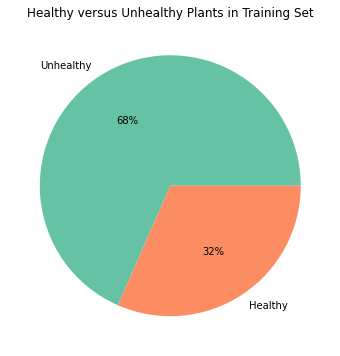

In [ ]:
plt.figure(figsize=(8,6))

palette_color = sns.color_palette('Set2')

plt.pie(train_df['Label'].value_counts(), labels=['Unhealthy', 'Healthy'], colors=palette_color, autopct='%.0f%%')

plt.title('Healthy versus Unhealthy Plants in Training Set')

plt.show()

In [ ]:
disease=train_df[train_df['Label']==0].shape[0]
healthy=train_df[train_df['Label']==1].shape[0]
print(f'Unhealthy plants qty in training set: {disease}')
print(f'Healthy plants qty in training set: {healthy}')
print(f'Class total in training set: {disease + healthy}')

Unhealthy plants qty in training set: 26
Healthy plants qty in training set: 12
Class total in training set: 38


In [ ]:
train_df[train_df['Label']==0]

Class  \
0                        Tomato___Tomato_mosaic_virus   
1                 Corn_(maize)___Northern_Leaf_Blight   
2                                   Apple___Black_rot   
3   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
4                                Tomato___Target_Spot   
5                                   Grape___Black_rot   
6                                  Apple___Apple_scab   
8                             Squash___Powdery_mildew   
9            Cherry_(including_sour)___Powdery_mildew   
10                           Strawberry___Leaf_scorch   
11           Orange___Haunglongbing_(Citrus_greening)   
14                              Tomato___Early_blight   
15                           Apple___Cedar_apple_rust   
16             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
20         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
21                      Pepper,_bell___Bacterial_spot   
24      Tomato___Spider_mites Two-spotted_spider_mite   
25                       Grape___Esca_(Black_Measles)   
28                        Corn_(maize)___Common_rust_   
30                        Tomato___Septoria_leaf_spot   
32                              Potato___Early_blight   
33                            Tomato___Bacterial_spot   
34                             Peach___Bacterial_spot   
35                                 Tomato___Leaf_Mold   
36                               Potato___Late_blight   
37                               Tomato___Late_blight   

                       Name  Label   Qty  
0                    Tomato      0  1790  
1              Corn_(maize)      0  1908  
2                     Apple      0  1987  
3              Corn_(maize)      0  1642  
4                    Tomato      0  1827  
5                     Grape      0  1888  
6                     Apple      0  2016  
8                    Squash      0  1736  
9   Cherry_(including_sour)      0  1683  
10               Strawberry      0  1774  
11                   Orange      0  2010  
14                   Tomato      0  1920  
15                    Apple      0  1760  
16                   Tomato      0  1961  
20                    Grape      0  1722  
21             Pepper,_bell      0  1913  
24                   Tomato      0  1741  
25                    Grape      0  1920  
28             Corn_(maize)      0  1907  
30                   Tomato      0  1745  
32                   Potato      0  1939  
33                   Tomato      0  1702  
34                    Peach      0  1838  
35                   Tomato      0  1882  
36                   Potato      0  1939  
37                   Tomato      0  1851

In [ ]:
train_df[train_df['Label']==1]

Class                     Name  Label   Qty
7                 Blueberry___healthy                Blueberry      1  1816
12                    Peach___healthy                    Peach      1  1728
13             Corn_(maize)___healthy             Corn_(maize)      1  1859
17                    Apple___healthy                    Apple      1  2008
18                Raspberry___healthy                Raspberry      1  1781
19               Strawberry___healthy               Strawberry      1  1824
22             Pepper,_bell___healthy             Pepper,_bell      1  1988
23  Cherry_(including_sour)___healthy  Cherry_(including_sour)      1  1826
26                  Soybean___healthy                  Soybean      1  2022
27                    Grape___healthy                    Grape      1  1692
29                   Potato___healthy                   Potato      1  1824
31                   Tomato___healthy                   Tomato      1  1926

In [ ]:
plants = train_df['Name'].unique()
plants

array(['Tomato', 'Corn_(maize)', 'Apple', 'Grape', 'Blueberry', 'Squash',
       'Cherry_(including_sour)', 'Strawberry', 'Orange', 'Peach',
       'Raspberry', 'Pepper,_bell', 'Soybean', 'Potato'], dtype=object)

In [ ]:
print(f'Plants in the training set are: {plants}')
print(f'Plants qty in the training set: {len(plants)}')

Plants in the training set are: ['Tomato' 'Corn_(maize)' 'Apple' 'Grape' 'Blueberry' 'Squash'
 'Cherry_(including_sour)' 'Strawberry' 'Orange' 'Peach' 'Raspberry'
 'Pepper,_bell' 'Soybean' 'Potato']
Plants qty in the training set: 14


In [ ]:
train_df[train_df['Label']==0].nlargest(10, columns='Qty')

Class          Name  Label   Qty
6                         Apple___Apple_scab         Apple      0  2016
11  Orange___Haunglongbing_(Citrus_greening)        Orange      0  2010
2                          Apple___Black_rot         Apple      0  1987
16    Tomato___Tomato_Yellow_Leaf_Curl_Virus        Tomato      0  1961
32                     Potato___Early_blight        Potato      0  1939
36                      Potato___Late_blight        Potato      0  1939
14                     Tomato___Early_blight        Tomato      0  1920
25              Grape___Esca_(Black_Measles)         Grape      0  1920
21             Pepper,_bell___Bacterial_spot  Pepper,_bell      0  1913
1        Corn_(maize)___Northern_Leaf_Blight  Corn_(maize)      0  1908

Text(0.5, 1.0, 'Top 10 Image Qty Per Unhealthy Plant in Training Set')

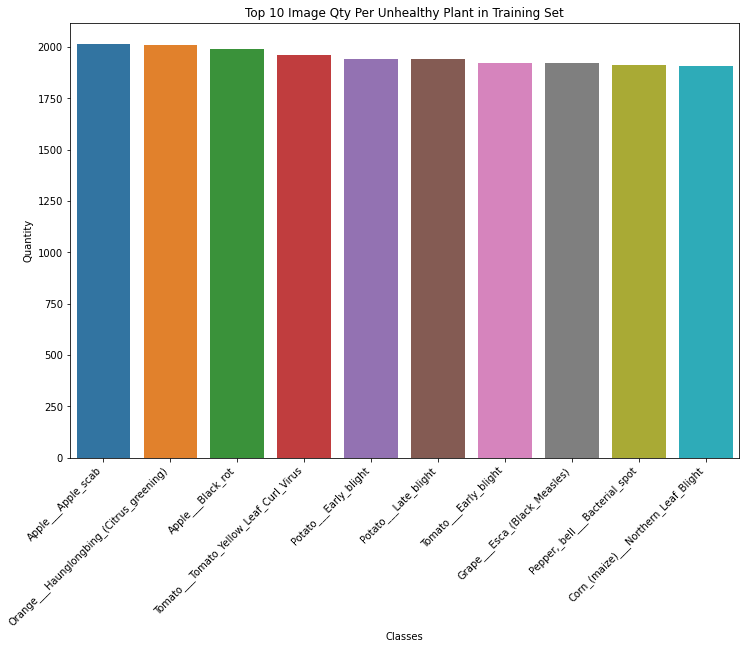

In [ ]:
plt.figure(figsize=(12, 8))

ax=sns.barplot(x='Class', y='Qty', data=train_df[train_df['Label']==0].nlargest(10, columns='Qty'))

ax.set_ylabel('Quantity')
ax.set_xlabel('Classes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Top 10 Image Qty Per Unhealthy Plant in Training Set', size=12)

In [ ]:
train_df[train_df['Label']==1].nlargest(10, columns='Qty')

Class                     Name  Label   Qty
26                  Soybean___healthy                  Soybean      1  2022
17                    Apple___healthy                    Apple      1  2008
22             Pepper,_bell___healthy             Pepper,_bell      1  1988
31                   Tomato___healthy                   Tomato      1  1926
13             Corn_(maize)___healthy             Corn_(maize)      1  1859
23  Cherry_(including_sour)___healthy  Cherry_(including_sour)      1  1826
19               Strawberry___healthy               Strawberry      1  1824
29                   Potato___healthy                   Potato      1  1824
7                 Blueberry___healthy                Blueberry      1  1816
18                Raspberry___healthy                Raspberry      1  1781

Text(0.5, 1.0, 'Top 10 Image Qty Per Healthy Plant in Training Set')

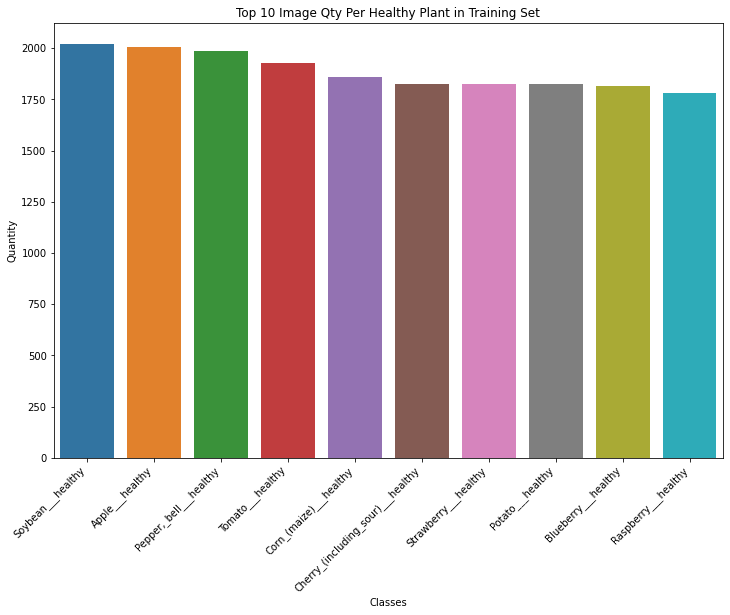

In [ ]:
plt.figure(figsize=(12, 8))

ax=sns.barplot(x='Class', y='Qty', data=train_df[train_df['Label']==1].nlargest(10, columns='Qty'))

ax.set_ylabel('Quantity')
ax.set_xlabel('Classes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_title('Top 10 Image Qty Per Healthy Plant in Training Set', size=12)

### Visualize validation data

In [ ]:
valid_class = os.listdir(valid_dir)
# Print the disease and non disease plants from the training set
valid_class

['Tomato___Tomato_mosaic_virus',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Apple___Black_rot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Tomato___Target_Spot',
 'Grape___Black_rot',
 'Apple___Apple_scab',
 'Blueberry___healthy',
 'Squash___Powdery_mildew',
 'Cherry_(including_sour)___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___healthy',
 'Corn_(maize)___healthy',
 'Tomato___Early_blight',
 'Apple___Cedar_apple_rust',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___healthy',
 'Raspberry___healthy',
 'Strawberry___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Grape___Esca_(Black_Measles)',
 'Soybean___healthy',
 'Grape___healthy',
 'Corn_(maize)___Common_rust_',
 'Potato___healthy',
 'Tomato___Septoria_leaf_spot',
 'Tomato___healthy',
 'Potato___Early_b

In [ ]:
valid_nms=[]
_= [valid_nms.append(x.split('___')[0]) for x in valid_class]
#valid_nms

In [ ]:
valid_lbls=[]
_= [valid_lbls.append(x.split('___')[1]) for x in valid_class]
#valid_lbls

In [ ]:
valid_df=pd.DataFrame(x, columns=['Class', 'Name', 'Label'])
valid_df['Label'] = valid_df['Label'].apply(lambda x: 1 if x == 'healthy' else 0)
valid_df['Qty'] = [len(os.listdir(valid_dir + '/' + x)) for x in valid_df['Class']]
valid_df

Class  \
0                        Tomato___Tomato_mosaic_virus   
1                 Corn_(maize)___Northern_Leaf_Blight   
2                                   Apple___Black_rot   
3   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
4                                Tomato___Target_Spot   
5                                   Grape___Black_rot   
6                                  Apple___Apple_scab   
7                                 Blueberry___healthy   
8                             Squash___Powdery_mildew   
9            Cherry_(including_sour)___Powdery_mildew   
10                           Strawberry___Leaf_scorch   
11           Orange___Haunglongbing_(Citrus_greening)   
12                                    Peach___healthy   
13                             Corn_(maize)___healthy   
14                              Tomato___Early_blight   
15                           Apple___Cedar_apple_rust   
16             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
17                                    Apple___healthy   
18                                Raspberry___healthy   
19                               Strawberry___healthy   
20         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
21                      Pepper,_bell___Bacterial_spot   
22                             Pepper,_bell___healthy   
23                  Cherry_(including_sour)___healthy   
24      Tomato___Spider_mites Two-spotted_spider_mite   
25                       Grape___Esca_(Black_Measles)   
26                                  Soybean___healthy   
27                                    Grape___healthy   
28                        Corn_(maize)___Common_rust_   
29                                   Potato___healthy   
30                        Tomato___Septoria_leaf_spot   
31                                   Tomato___healthy   
32                              Potato___Early_blight   
33                            Tomato___Bacterial_spot   
34                             Peach___Bacterial_spot   
35                                 Tomato___Leaf_Mold   
36                               Potato___Late_blight   
37                               Tomato___Late_blight   

                       Name  Label  Qty  
0                    Tomato      0  448  
1              Corn_(maize)      0  477  
2                     Apple      0  497  
3              Corn_(maize)      0  410  
4                    Tomato      0  457  
5                     Grape      0  472  
6                     Apple      0  504  
7                 Blueberry      1  454  
8                    Squash      0  434  
9   Cherry_(including_sour)      0  421  
10               Strawberry      0  444  
11                   Orange      0  503  
12                    Peach      1  432  
13             Corn_(maize)      1  465  
14                   Tomato      0  480  
15                    Apple      0  440  
16                   Tomato      0  490  
17                    Apple      1  502  
18                Raspberry      1  445  
19               Strawberry      1  456  
20                    Grape      0  430  
21             Pepper,_bell      0  478  
22             Pepper,_bell      1  497  
23  Cherry_(including_sour)      1  456  
24                   Tomato      0  435  
25                    Grape      0  480  
26                  Soybean      1  505  
27                    Grape      1  423  
28             Corn_(maize)      0  477  
29                   Potato      1  456  
30                   Tomato      0  436  
31                   Tomato      1  481  
32                   Potato      0  485  
33                   Tomato      0  425  
34                    Peach      0  459  
35                   Tomato      0  470  
36                   Potato      0  485  
37                   Tomato      0  463

In [ ]:
valid_df['Label'].value_counts()

0    26
1    12
Name: Label, dtype: int64

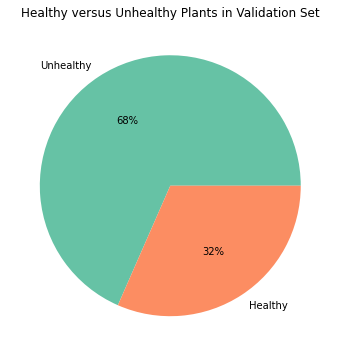

In [ ]:
plt.figure(figsize=(8,6))

palette_color = sns.color_palette('Set2')

plt.pie(valid_df['Label'].value_counts(), labels=['Unhealthy', 'Healthy'], colors=palette_color, autopct='%.0f%%')

plt.title('Healthy versus Unhealthy Plants in Validation Set')

plt.show()

In [ ]:
disease=valid_df[valid_df['Label']==0].shape[0]
healthy=valid_df[valid_df['Label']==1].shape[0]
print(f'Unhealthy plants qty in validation set: {disease}')
print(f'Healthy plants qty in validation set: {healthy}')
print(f'Class total in validation set: {disease + healthy}')

Unhealthy plants qty in validation set: 26
Healthy plants qty in validation set: 12
Class total in validation set: 38


### Compare train and validation set

In [ ]:
print(f'Train images qty: {train_df["Qty"].sum()}')
print(f'Valid images qty: {valid_df["Qty"].sum()}')

Train images qty: 70295
Valid images qty: 17572


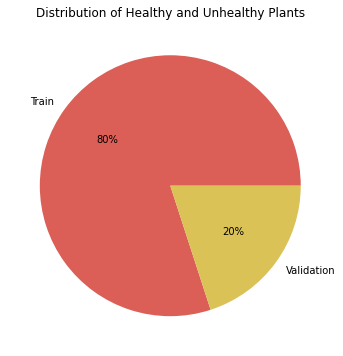

In [ ]:
plt.figure(figsize=(8,6))

palette_color = sns.color_palette('hls', 8) #sns.color_palette('Set3')

plt.pie([train_df['Qty'].sum(), valid_df['Qty'].sum()], labels=['Train', 'Validation'], colors=palette_color, autopct='%.0f%%')

plt.title('Distribution of Healthy and Unhealthy Plants')

plt.show()

#3.Preprocessing

### Datasets for validation and training

In [ ]:
dataset_train = ImageFolder(train_dir, transform=transforms.ToTensor())
dataset_valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

### Image shape

In [ ]:
img, label = img, label = dataset_train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


### Total number of classes in training set

In [ ]:
len(dataset_train.classes)

38

### Dataloader for training and validation

In [ ]:
batch=64

In [ ]:
train_loader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch, shuffle=False)

In [ ]:
def show_batch(data):
  for images, labels in data:
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

### Images for first batch of training

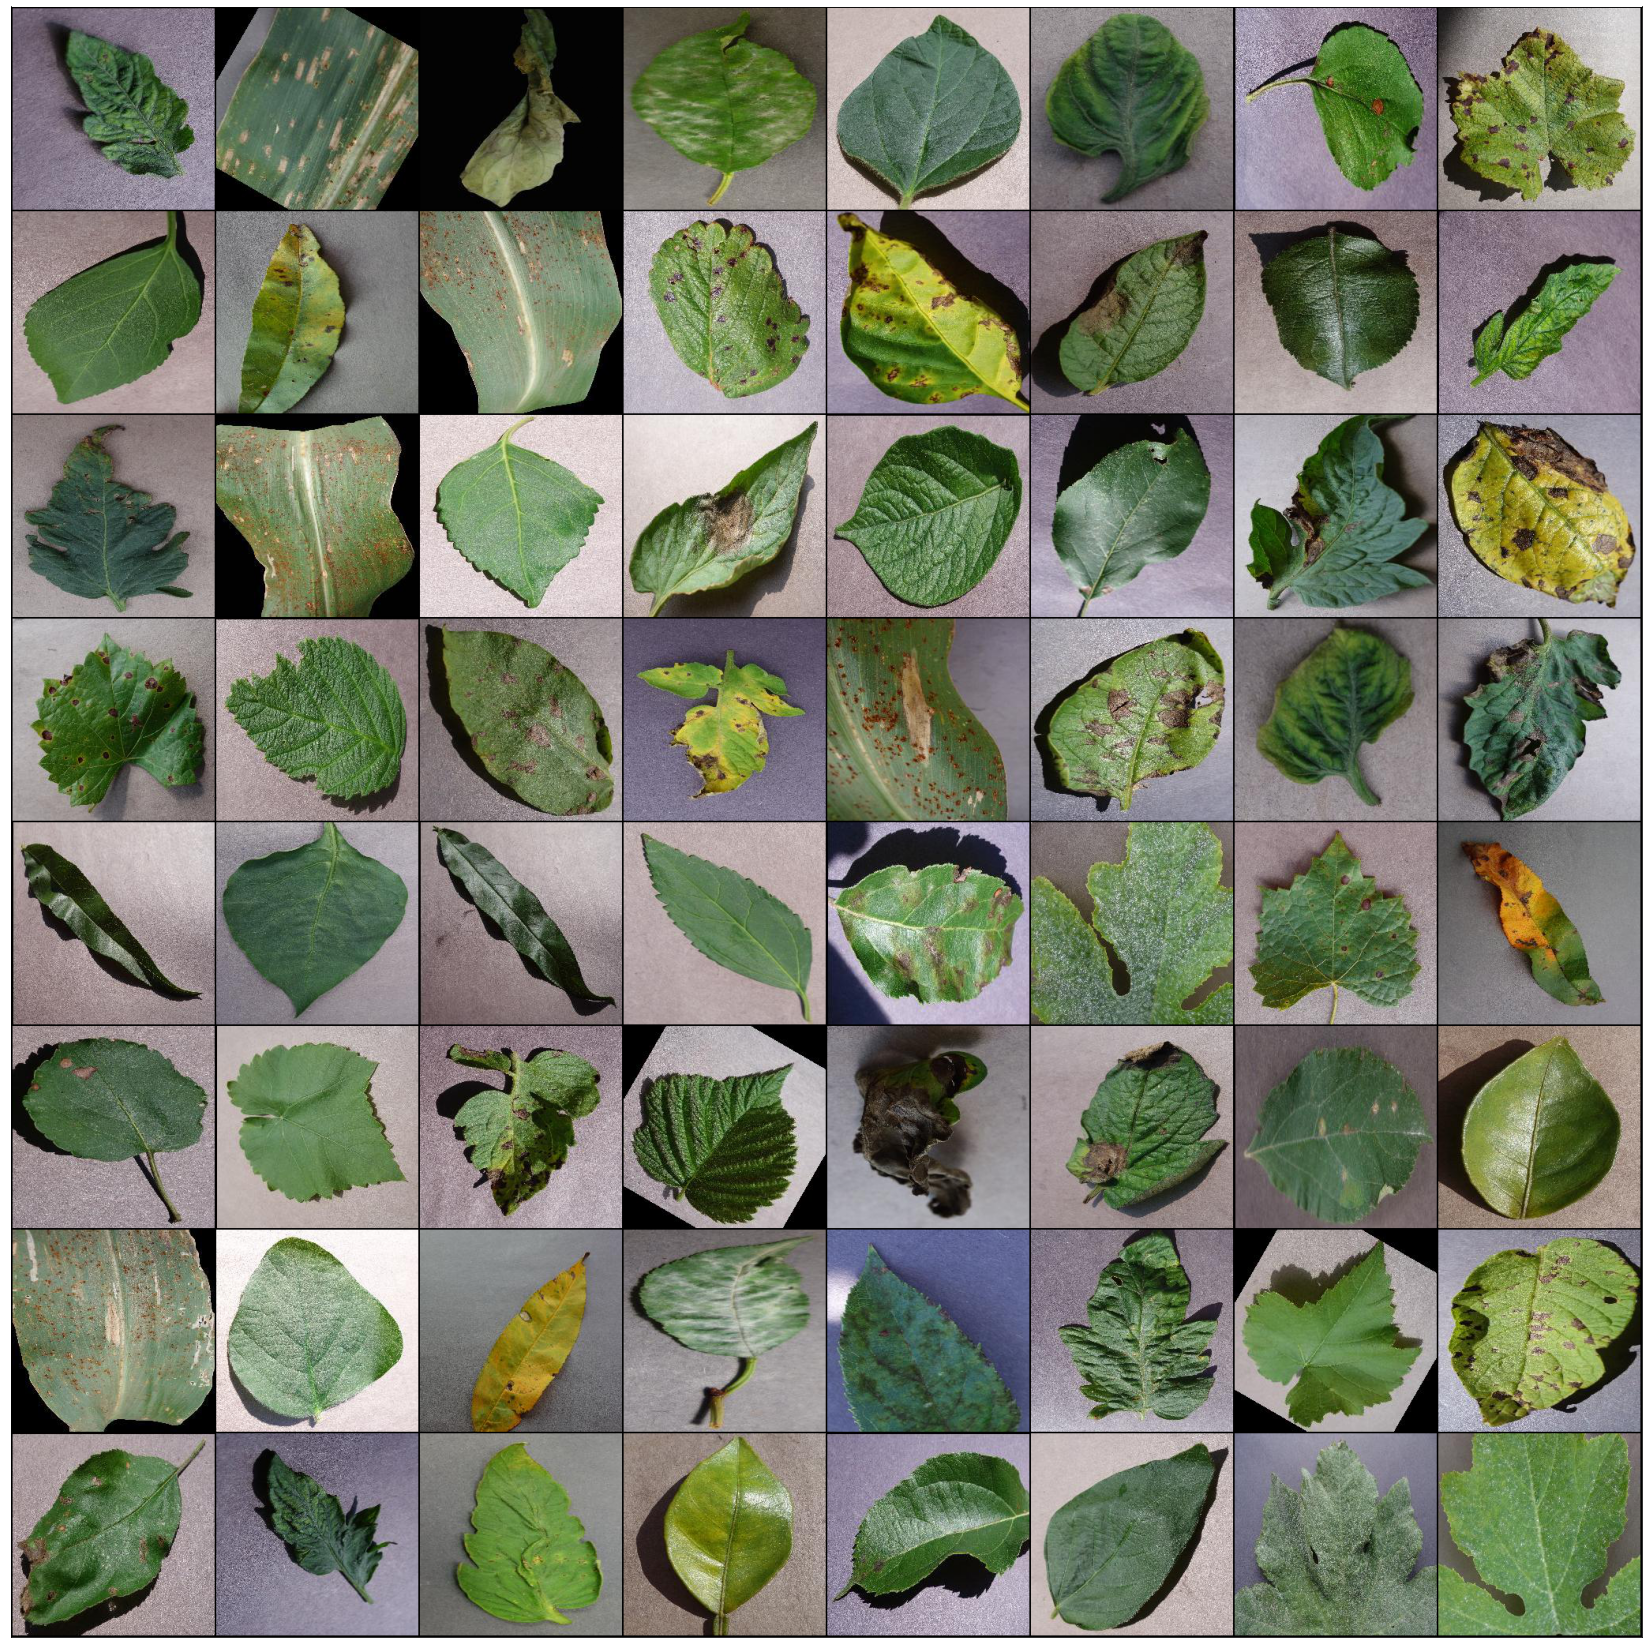

In [ ]:
show_batch(train_loader)

#4.Model Definition

**RESNET**

A residual network, or ResNet for short, is a DNN that helps to build deeper neural networks by utilizing skip connections or shortcuts to jump over some layers. This helps solve the problem of vanishing gradients.

There are different versions of ResNet, including ResNet-18, ResNet-34, ResNet-50, and so on. The numbers denote layers, although the architecture is the same.

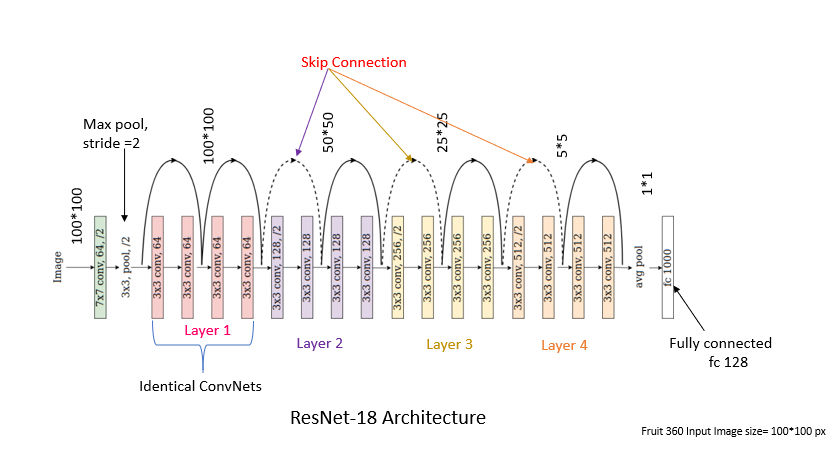

**References**:

- https://arxiv.org/pdf/1512.03385v1.pdf

- https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8#:~:text=Understanding%20and%20visualizing%20ResNets



**RESNET18**

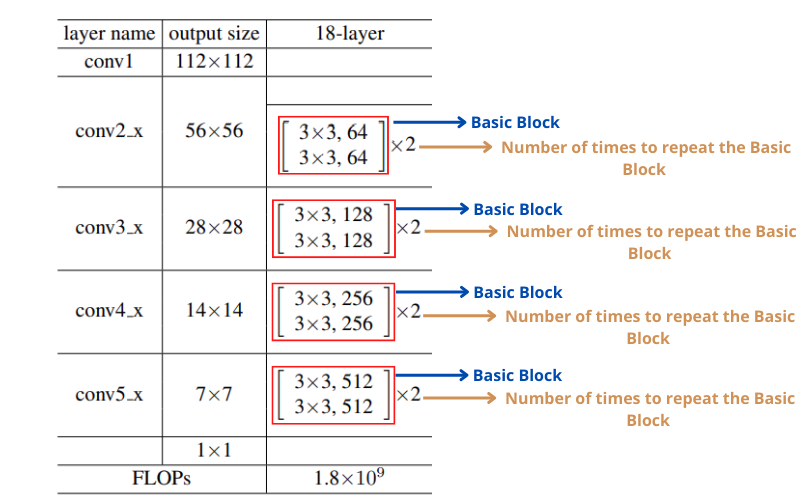

For **ResNet18** (as well as for other ResNet variants), we have four different types of Basic Blocks. If you observe, the only change that occurs across the Basic Blocks (conv2_x to conv5_x) is in the number of input and output channels. We need not define these blocks multiple times. We can define one simple Python class which will take care of everything according to the logic that we implement.

The numbers beside each block represent how many times we need to repeat the Basic Blocks while building the network. It is the same (2) for all Basic Blocks of ResNet18.

In other words, each conv2_x to conv5_x will contain 2 Basic Blocks stacked together one after the other. Let’s call conv2_x to conv5_x as layer1 to layer4:

- conv2_x => layer1
- conv3_x => layer2
- conv4_x => layer3
- conv5_x => layer4

**References:**

- https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4,
                               kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(
            out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)

        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, outputs, useBottleneck=False):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (
                    i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (
                i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,),resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        # torch.flatten()
        # https://stackoverflow.com/questions/60115633/pytorch-flatten-doesnt-maintain-batch-size
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

## Summary

In [ ]:
resnet18 = ResNet(3, ResBlock, [2, 2, 2, 2], outputs=len(dataset_train.classes), useBottleneck=False)
resnet18.to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
summary(resnet18, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,472
         MaxPool2d-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7           [-1, 64, 64, 64]          36,928
       BatchNorm2d-8           [-1, 64, 64, 64]             128
          ResBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,928
      BatchNorm2d-11           [-1, 64, 64, 64]             128
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
         ResBlock-14           [-1, 64,

#5.Model Training

In [ ]:
# Plot the accuracy and loss
def save_plots(train_acc, valid_acc, train_loss, valid_loss, name=None):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(name+'_accuracy.png')

    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(name+'_loss.png')

In [ ]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

## Set some parameters

#### Seed

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(seed)
random.seed(seed)

#### Learning and training parameters

In [ ]:
epochs = 30
batch_size = 64
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### Optimizer

In [ ]:
optimizer = optim.SGD(resnet18.parameters(), lr=learning_rate)

#### Loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

## Training execution

[INFO]: Epoch 1 of 30
Training


100%|██████████| 1099/1099 [04:25<00:00,  4.13it/s]


Validation


100%|██████████| 275/275 [01:01<00:00,  4.47it/s]


Training loss: 1.019, training acc: 71.877
Validation loss: 1.423, validation acc: 58.371
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


100%|██████████| 1099/1099 [04:04<00:00,  4.49it/s]


Validation


100%|██████████| 275/275 [00:59<00:00,  4.66it/s]


Training loss: 0.299, training acc: 91.220
Validation loss: 1.369, validation acc: 66.856
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


100%|██████████| 1099/1099 [04:06<00:00,  4.47it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.76it/s]


Training loss: 0.173, training acc: 94.910
Validation loss: 0.406, validation acc: 87.787
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.77it/s]


Training loss: 0.116, training acc: 96.597
Validation loss: 0.756, validation acc: 77.948
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.66it/s]


Training loss: 0.088, training acc: 97.425
Validation loss: 0.657, validation acc: 81.391
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.75it/s]


Training loss: 0.066, training acc: 98.135
Validation loss: 1.032, validation acc: 70.891
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.72it/s]


Training loss: 0.055, training acc: 98.434
Validation loss: 1.027, validation acc: 71.881
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.67it/s]


Training loss: 0.047, training acc: 98.740
Validation loss: 0.583, validation acc: 83.514
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


100%|██████████| 1099/1099 [04:12<00:00,  4.35it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.74it/s]


Training loss: 0.037, training acc: 98.986
Validation loss: 0.293, validation acc: 90.832
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.76it/s]


Training loss: 0.032, training acc: 99.101
Validation loss: 0.204, validation acc: 95.658
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.67it/s]


Training loss: 0.028, training acc: 99.309
Validation loss: 0.035, validation acc: 98.970
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.74it/s]


Training loss: 0.023, training acc: 99.415
Validation loss: 0.065, validation acc: 97.911
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.74it/s]


Training loss: 0.018, training acc: 99.577
Validation loss: 0.035, validation acc: 98.902
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.69it/s]


Training loss: 0.016, training acc: 99.605
Validation loss: 0.058, validation acc: 98.168
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.67it/s]


Training loss: 0.016, training acc: 99.609
Validation loss: 0.021, validation acc: 99.357
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.69it/s]


Training loss: 0.013, training acc: 99.667
Validation loss: 0.070, validation acc: 97.763
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.70it/s]


Training loss: 0.011, training acc: 99.795
Validation loss: 0.155, validation acc: 95.277
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.75it/s]


Training loss: 0.010, training acc: 99.784
Validation loss: 1.907, validation acc: 63.903
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.67it/s]


Training loss: 0.012, training acc: 99.738
Validation loss: 0.035, validation acc: 98.930
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.75it/s]


Training loss: 0.007, training acc: 99.905
Validation loss: 0.021, validation acc: 99.340
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.74it/s]


Training loss: 0.006, training acc: 99.925
Validation loss: 0.016, validation acc: 99.550
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.67it/s]


Training loss: 0.007, training acc: 99.848
Validation loss: 0.037, validation acc: 98.720
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.73it/s]


Training loss: 0.007, training acc: 99.869
Validation loss: 0.015, validation acc: 99.522
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.66it/s]


Training loss: 0.006, training acc: 99.873
Validation loss: 0.017, validation acc: 99.482
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.77it/s]


Training loss: 0.005, training acc: 99.920
Validation loss: 0.018, validation acc: 99.459
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.75it/s]


Training loss: 0.003, training acc: 99.967
Validation loss: 0.013, validation acc: 99.607
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:59<00:00,  4.65it/s]


Training loss: 0.005, training acc: 99.892
Validation loss: 0.103, validation acc: 96.466
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:58<00:00,  4.74it/s]


Training loss: 0.003, training acc: 99.967
Validation loss: 0.064, validation acc: 98.219
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


100%|██████████| 1099/1099 [04:08<00:00,  4.43it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.74it/s]


Training loss: 0.003, training acc: 99.953
Validation loss: 0.016, validation acc: 99.494
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


100%|██████████| 1099/1099 [04:07<00:00,  4.44it/s]


Validation


100%|██████████| 275/275 [00:57<00:00,  4.76it/s]


Training loss: 0.003, training acc: 99.966
Validation loss: 0.012, validation acc: 99.647
--------------------------------------------------
TRAINING COMPLETE


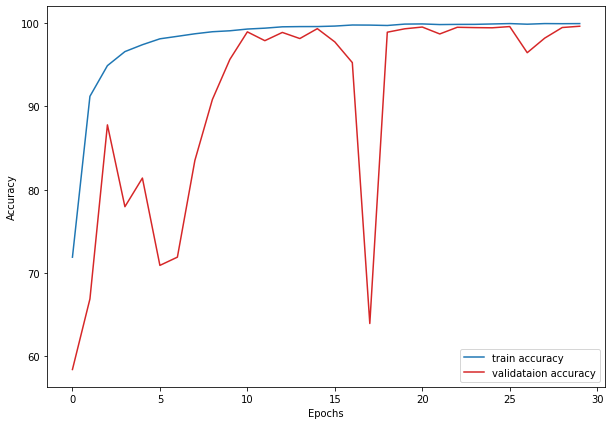

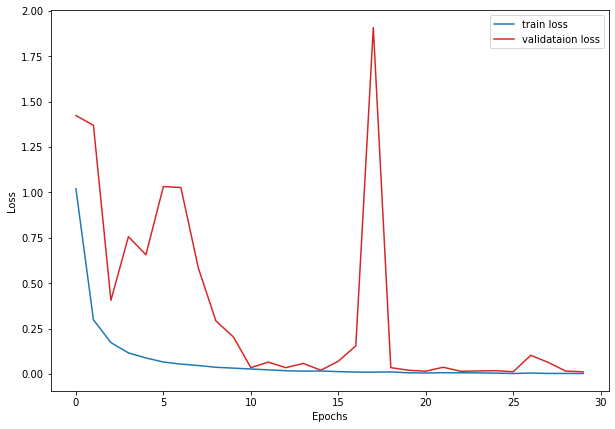

In [ ]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        resnet18,
        train_loader,
        optimizer,
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        resnet18,
        valid_loader,
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

# Save the loss and accuracy plots.
save_plots(
    train_acc,
    valid_acc,
    train_loss,
    valid_loss,
    name='resnet_scratch'
)
print('TRAINING COMPLETE')

In [ ]:
torch.save(resnet18.state_dict(), './leaf_disease_detection_model.pth')

## Testing model on testing data

In [ ]:
test_dir = './test/'

In [ ]:
dataset_test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
# rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
test_images = sorted(os.listdir(test_dir + '/test'))
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [ ]:
# For moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
def predict_image_(img, model):
  """Converts image to array and return the predicted class
     with highest probability"""
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get predictions from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds  = torch.max(yb, dim=1)
  # Retrieve the class label

  return dataset_train.classes[preds[0].item()]

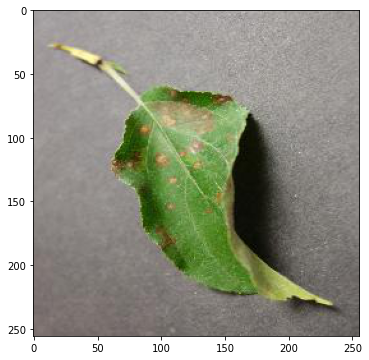

In [ ]:
# Predicting a random image
img, label = dataset_test[2]
plt.figure(figsize=(8,6))
plt.imshow(img.permute(1, 2, 0))

In [ ]:
print('Label:', test_images[2], ', Predicted:', predict_image_(img, resnet18))

Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust


In [ ]:
# Getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(dataset_test):
    print('Label:', test_images[i], ', Predicted:', predict_image_(img, resnet18))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___h

#7.Model Save

In [ ]:
torch.save(resnet18.state_dict(), './leaf_disease_detection_model.pth')

#8.Model Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rsnt18 = ResNet(3, ResBlock, [2, 2, 2, 2], outputs=len(dataset_train.classes), useBottleneck=False)
rsnt18.fc = nn.Linear(rsnt18.fc.in_features, 38)
rsnt18 = rsnt18.to(device)
rsnt18.load_state_dict(torch.load('./leaf_disease_detection_model.pth', map_location=device))

<All keys matched successfully>

In [ ]:
rsnt18.eval()
rsnt18

ResNet(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1): Sequential(
    (conv2_1): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2_2): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [ ]:
def predict_image(image):
  image_tensor = transforms.ToTensor()(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = rsnt18(input)
  index = output.data.cpu().numpy().argmax()

  return index

In [ ]:
def get_random_images(num, dir):
  data = ImageFolder(dir, transform=transforms.ToTensor())
  classes = data.classes
  indices = list(range(len(data)))
  np.random.shuffle(indices)
  idx = indices[:num]
  sampler = SubsetRandomSampler(idx)
  loader = DataLoader(data, sampler=sampler, batch_size=num)
  dataiter = iter(loader)
  images, labels = next(dataiter)

  return images, labels

## Predict labeled data

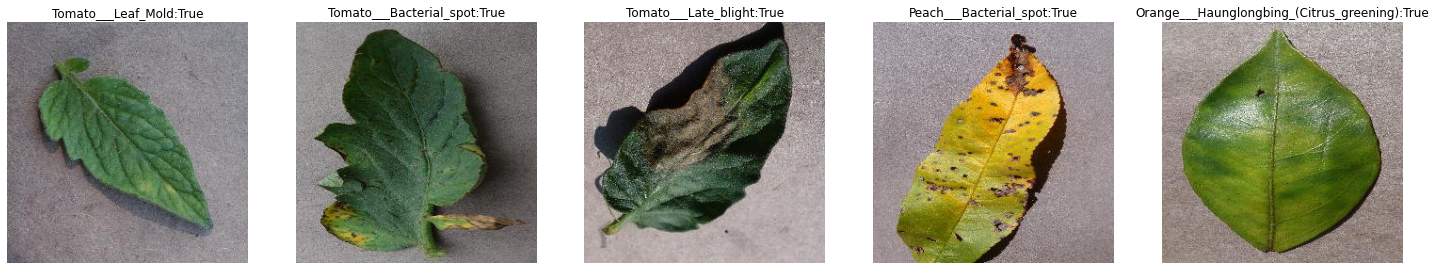

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, valid_dir)
fig=plt.figure(figsize=(25,25))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(dataset_train.classes[index]) + ":" + str(res))

    plt.axis('off')
    plt.imshow(image)
plt.show()